# 2016-10-07: Regularized Logistic Regression
In this lab, we will appply logistic regression to the Endometrium vs. Uterus cancer data.

Let us start by setting up our environment, loading the data, and setting up our cross-validation.

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))

# Python 3
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', 
               skiprows=1, usecols=[3001], dtype='bytes').astype('str')
#Convert 'Endometrium' to 0 and 'Uterus' to 1
y = np.where(y=='Endometrium', 0, 1)

print(y)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [3]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)

In [4]:
# Create a function that does cross-validation and scales the features on each training set.
from sklearn import preprocessing
def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
    Use a scaler to scale the features to mean 0, standard deviation 1.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape) # vector of 0 in which to store the predictions
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        #print Xtr.shape, ytr.shape, Xte.shape

        # Scale data
        scaler = preprocessing.StandardScaler() # create scaler
        Xtr = scaler.fit_transform(Xtr) # fit the scaler to the training data and transform training data
        Xte = scaler.transform(Xte) # transform test data

        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte) # two-dimensional array
        # Identify the index, in yte_pred, of the positive class (y=1)
        # index_of_class_1 = np.nonzero(classifier.classes_ == 1)[0][0] 
        index_of_class_1 = 1 - ytr[0] # 0 if the first sample is positive, 1 otherwise
        pred[te] = yte_pred[:, index_of_class_1]                
    return pred

## 1. L1-Regularized Logistic Regression 

Let us start with default parameters.

In [5]:
from sklearn import linear_model
clf_L1 = linear_model.LogisticRegression(penalty='l1')
clf = linear_model.LogisticRegression(C=1e6)

**Question** Compute the cross-validated predictions of the l1-regularized logistic regression with default parameters on our data.

In [6]:
#with penalty L1
ypred_logreg_L1 = cross_validate_with_scaling(X,y,clf_L1,folds)

#without penalty
ypred_logreg = cross_validate_with_scaling(X,y,clf,folds)

**Question** Plot the corresponding ROC curve, and compare it to that obtained for non-regularized logistic regression.

Accuracy: 0.798
Accuracy with L1 regularization: 0.705


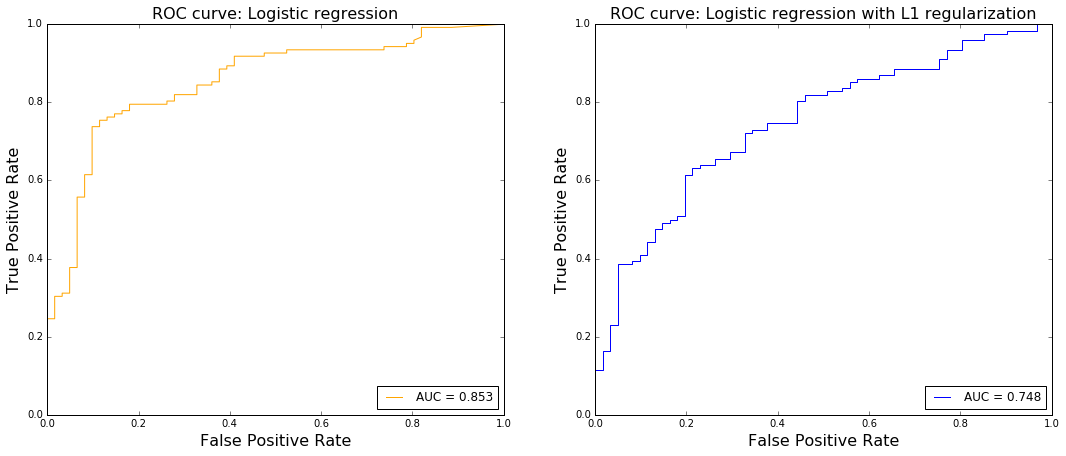

In [7]:
from sklearn import metrics

#Compute fpr, tpr
fpr_logreg, tpr_logreg, thresholds = metrics.roc_curve(y, ypred_logreg, pos_label=1)
fpr_logreg_L1, tpr_logreg_L1, thresholds_L1 = metrics.roc_curve(y, ypred_logreg_L1, pos_label=1)

#Transform ypred_logreg into a binary list
ypred_logreg = np.array(ypred_logreg)
pred = [(x >= 0.5).astype(int) for x in ypred_logreg]
#Transform ypred_logreg into a binary list
ypred_logreg_L1 = np.array(ypred_logreg_L1)
pred_L1 = [(x >= 0.5).astype(int) for x in ypred_logreg_L1]

print("Accuracy: %.3f" % metrics.accuracy_score(y, pred))
print("Accuracy with L1 regularization: %.3f" % metrics.accuracy_score(y, pred_L1))

#Compute AUC
auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)
auc_logreg_L1 = metrics.auc(fpr_logreg_L1, tpr_logreg_L1)

#Plot
fig = plt.figure(figsize=(18, 7))

#Plot without regularization
fig.add_subplot(121) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg, tpr_logreg, '-', color='orange', label='AUC = %0.3f' % auc_logreg)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(loc="lower right")

#Plot with regularization
fig.add_subplot(122) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg_L1, tpr_logreg_L1, '-', color='blue', label='AUC = %0.3f' % auc_logreg_L1)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression with L1 regularization', fontsize=16)
plt.legend(loc="lower right")

### Setting the C parameter
What does the C parameter correspond to? See the documentation at http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression for help.

Scikit-learn makes it really easy to use a nested cross-validation to choose a good value for C among a grid of several choices.

In [8]:
from sklearn import grid_search 
param_grid = {'C':[1e-3, 1e-2, 1e-1, 1., 1e2, 1e3]}
#clf_L1_optimized = linear_model.LogisticRegression(penalty='l1')
#clf_L1_optimized = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l1'), param_grid)

**Question** What criterion is used to chose the optimal C? See the documentation at http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV.  Try changing this criterion http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter 

In [9]:
param_grid = {'C': np.power(10.0, np.arange(-10, 10))}
clf_L1_optimized = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l1'), param_grid)

**Question** Compute the cross-validated predictions of the l1-regularized logistic regression with optimized C parameter on our data.

Accuracy: 0.798
Accuracy with L1 regularization: 0.705
Accuracy with L1 regularization optimized: 0.710


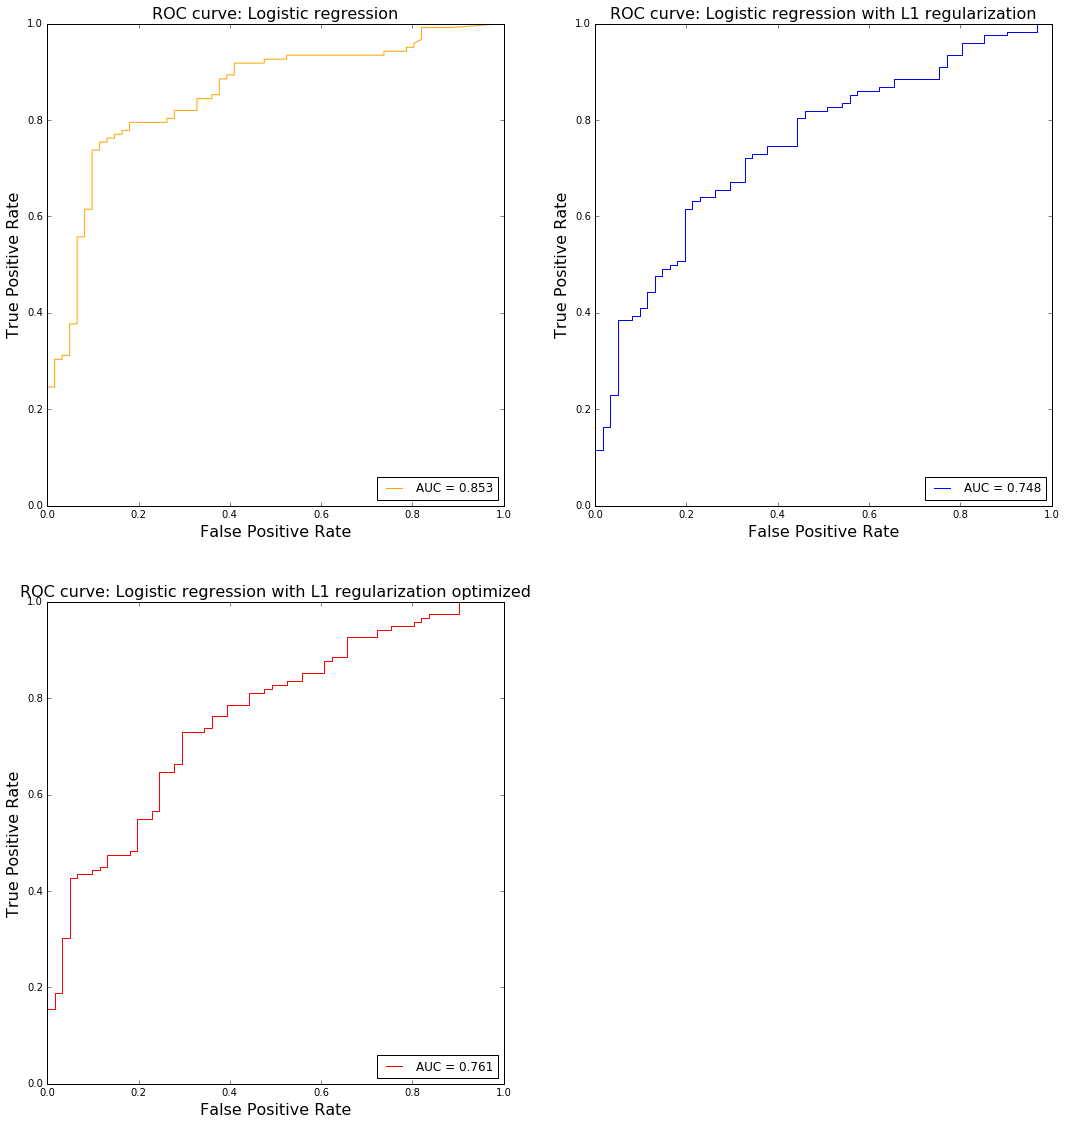

In [10]:
ypred_logreg_L1_optimized = cross_validate_with_scaling(X,y,clf_L1_optimized,folds)
#Compute fpr, tpr
fpr_logreg_L1_optimized, tpr_logreg_L1_optimized, thresholds_L1_optimized = metrics.roc_curve(y, ypred_logreg_L1_optimized, pos_label=1)

#Transform ypred_logreg into a binary list
ypred_logreg_L1_optimized = np.array(ypred_logreg_L1_optimized)
pred_L1_optimized = [(x >= 0.5).astype(int) for x in ypred_logreg_L1_optimized]

print("Accuracy: %.3f" % metrics.accuracy_score(y, pred))
print("Accuracy with L1 regularization: %.3f" % metrics.accuracy_score(y, pred_L1))
print("Accuracy with L1 regularization optimized: %.3f" % metrics.accuracy_score(y, pred_L1_optimized))

#Compute AUC
auc_logreg_L1_optimized = metrics.auc(fpr_logreg_L1_optimized, tpr_logreg_L1_optimized)

#Plot
fig = plt.figure(figsize=(18, 19))

#Plot without regularization
fig.add_subplot(221) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg, tpr_logreg, '-', color='orange', label='AUC = %0.3f' % auc_logreg)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(loc="lower right")

#Plot with regularization
fig.add_subplot(222) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg_L1, tpr_logreg_L1, '-', color='blue', label='AUC = %0.3f' % auc_logreg_L1)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression with L1 regularization', fontsize=16)
plt.legend(loc="lower right")

#Plot with regularization
fig.add_subplot(223) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg_L1_optimized, tpr_logreg_L1_optimized, '-', color='red', label='AUC = %0.3f' % auc_logreg_L1_optimized)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression with L1 regularization optimized', fontsize=16)
plt.legend(loc="lower right")

GridSearchCV also uses the optimal parameter(s) it detected to fit a model to its entire training data again, generating a "best model" that is accessible via the `best_estimator_` attribute.

In our case, because we called GridSearchCV from inside a cross-validation loop, `clf.best_estimator_` is the "best model" *on the last training fold*.

In [11]:
print(clf_L1_optimized.best_estimator_)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Regression weights
Remember the goal of l1-regularization is to build sparse models. 

(0, 3000)

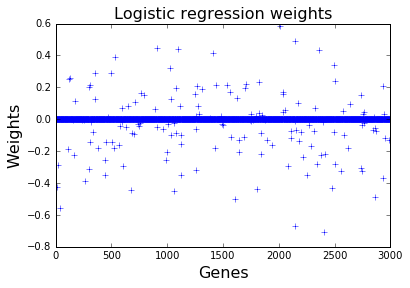

In [14]:
# This code plots the regression weights of the classifier 'clf'
plt.plot(range(len(clf_L1_optimized.best_estimator_.coef_[0])), clf_L1_optimized.best_estimator_.coef_[0], 
         color='blue', marker='+', linestyle='')
plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.xlim([0, X.shape[1]])

**Question** Compare the regression weights obtained with and without l1-regularization, in two side-by-side plots.

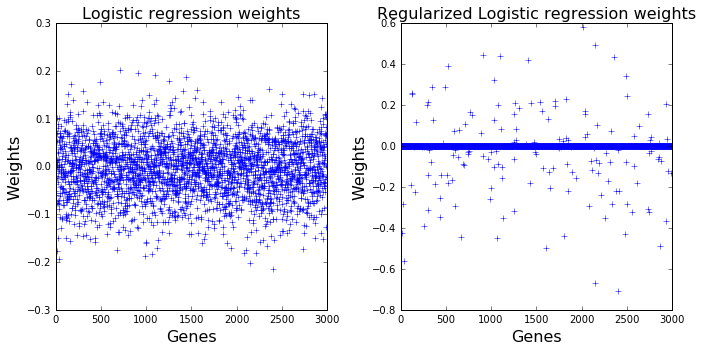

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121) # use a 1x2 subplot grid; ax will refer to the 1st subplot

number_of_weights = len(clf_L1_optimized.best_estimator_.coef_[0])
logreg_weights = clf.coef_[0]

ax.plot(range(number_of_weights), logreg_weights,color='blue', marker='+', linestyle='')
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Logistic regression weights', fontsize=16)
ax.set_xlim([0, X.shape[1]])

ax = fig.add_subplot(122) # use a 1x2 subplot grid; ax will refer to the 2nd subplot

l1_logreg_weights = clf_L1_optimized.best_estimator_.coef_[0]

ax.plot(range(number_of_weights), l1_logreg_weights,color='blue', marker='+', linestyle='')
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Regularized Logistic regression weights', fontsize=16)
ax.set_xlim([0, X.shape[1]])
plt.tight_layout()

## 2. L2-regularized logistic regression

**Question** What is the role of l2 regularization?

L2 regularization gives similar weights to similar variables and provides an analytical solution

In [16]:
#clf_L2 = linear_model.LogisticRegression(penalty='l2')
clf_L2 = grid_search.GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid)

**Question** Compute the cross-validated predictions of an l2-regularized logistic regression with optimized C parameters on our data.

In [17]:
ypred_logreg_L2 = cross_validate_with_scaling(X,y,clf_L2,folds)

**Question** Plot the corresponding ROC curve, and compare to that obtained for
* non-regularized logistic regression
* l1-regularized logistic regression (with optimized C parameter)

Accuracy: 0.798
Accuracy with L1 regularization optimized: 0.710
Accuracy with L2: 0.776


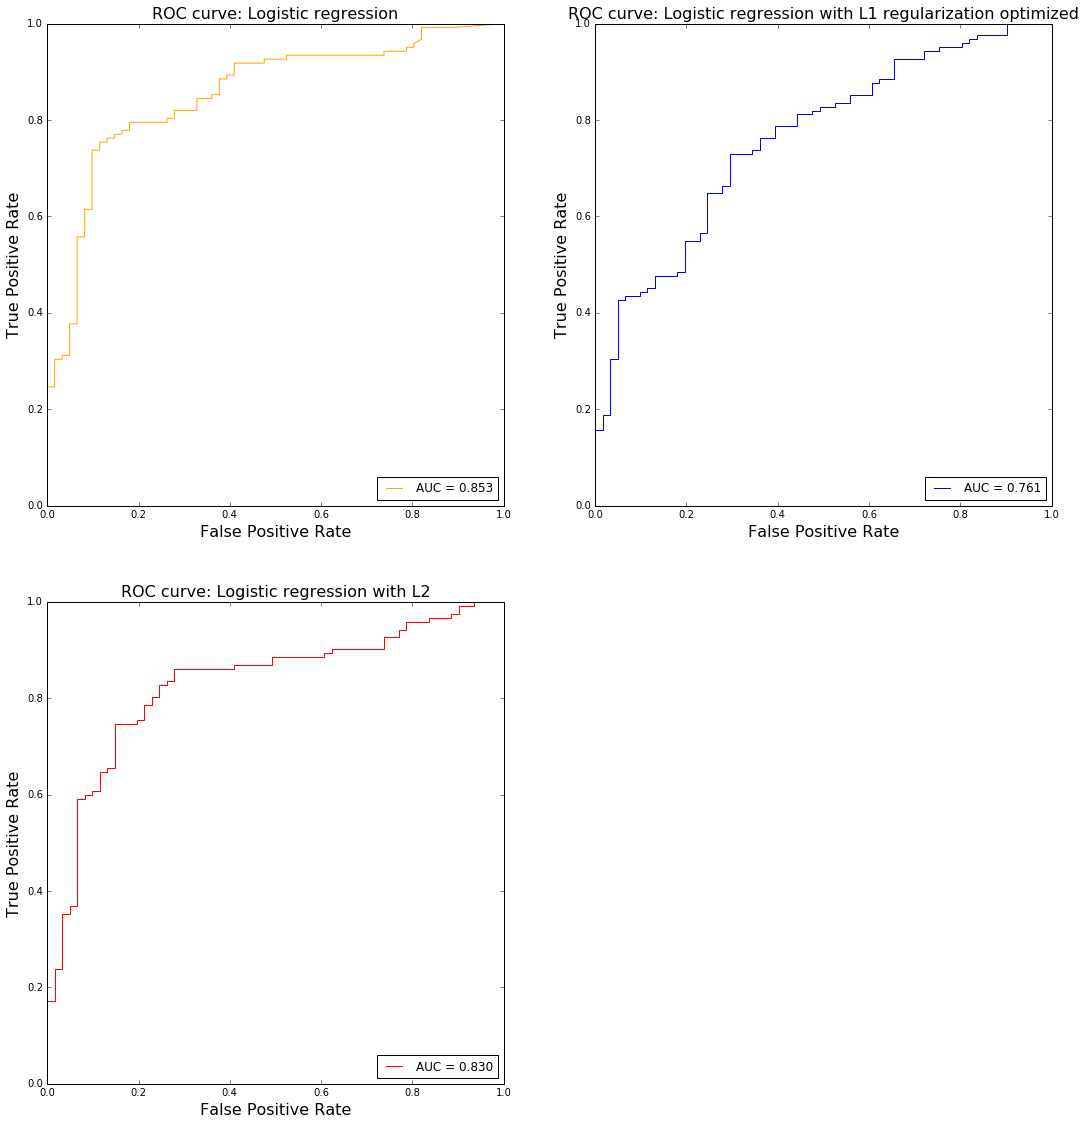

In [18]:
#Compute fpr, tpr
fpr_logreg_L2, tpr_logreg_L2, thresholds_L2 = metrics.roc_curve(y, ypred_logreg_L2, pos_label=1)

#Transform ypred_logreg into a binary list
ypred_logreg_L2 = np.array(ypred_logreg_L2)
pred_L2 = [(x >= 0.5).astype(int) for x in ypred_logreg_L2]

print("Accuracy: %.3f" % metrics.accuracy_score(y, pred))
print("Accuracy with L1 regularization optimized: %.3f" % metrics.accuracy_score(y, pred_L1_optimized))
print("Accuracy with L2: %.3f" % metrics.accuracy_score(y, pred_L2))

#Compute AUC
auc_logreg_L2 = metrics.auc(fpr_logreg_L2, tpr_logreg_L2)

#Plot
fig = plt.figure(figsize=(18, 19))

#Plot without regularization
fig.add_subplot(221) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg, tpr_logreg, '-', color='orange', label='AUC = %0.3f' % auc_logreg)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(loc="lower right")

#Plot with regularization
fig.add_subplot(222) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg_L1_optimized, tpr_logreg_L1_optimized, '-', color='blue', label='AUC = %0.3f' % auc_logreg_L1_optimized)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression with L1 regularization optimized', fontsize=16)
plt.legend(loc="lower right")

#Plot with regularization
fig.add_subplot(223) # 2 x 2 grid, 1st subplot
plt.plot(fpr_logreg_L2, tpr_logreg_L2, '-', color='red', label='AUC = %0.3f' % auc_logreg_L2)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression with L2', fontsize=16)
plt.legend(loc="lower right")

In [19]:
print(clf_L2.best_estimator_)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


**Question** Compare the regression weights obtained with l2-regularization to those obtained 
* with l1-regularization.
* with no regularization.
Do your observations match your expectations?

**Answer** Indeed, with L1-regularization, the model is spare : very few weights are not null. With l2-regularization, the model is not sparse anymore but the weights are very weak compared to the model obtained without any regularization.

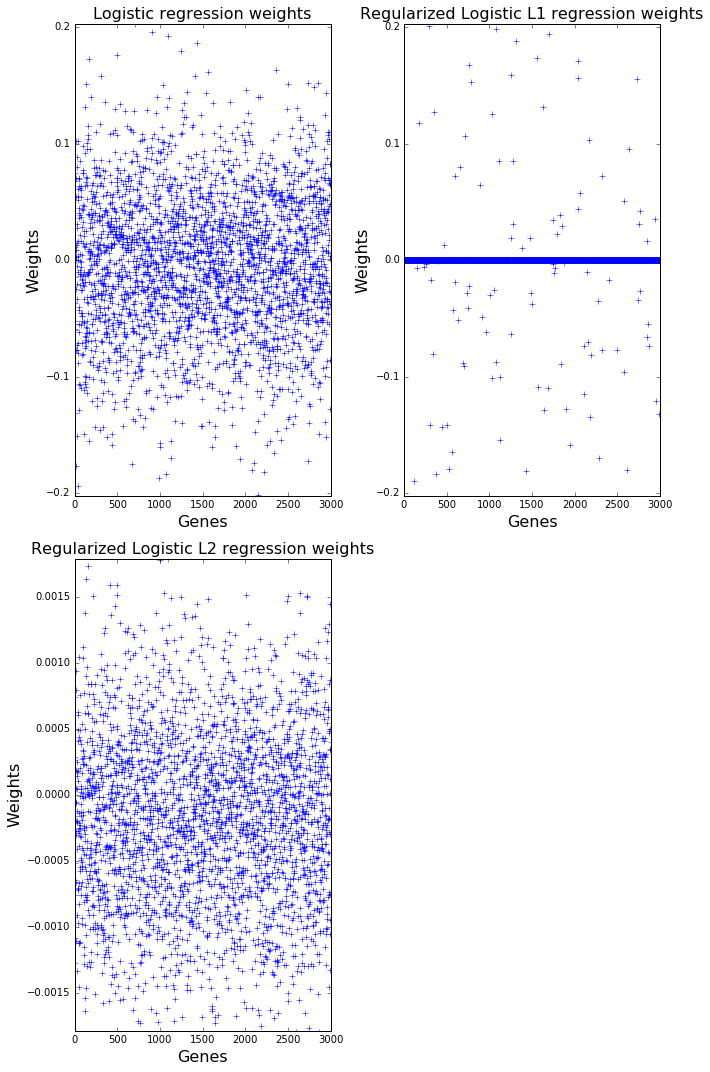

In [21]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(221) # use a 1x2 subplot grid; ax will refer to the 1st subplot

number_of_weights = len(clf_L1_optimized.best_estimator_.coef_[0])
logreg_weights = clf.coef_[0]

y_lim = max(logreg_weights)

ax.plot(range(number_of_weights), logreg_weights,color='blue', marker='+', linestyle='')
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Logistic regression weights', fontsize=16)
ax.set_xlim([0, X.shape[1]])
ax.set_ylim([-y_lim,y_lim])

ax = fig.add_subplot(222) # use a 1x2 subplot grid; ax will refer to the 2nd subplot

l1_logreg_weights = clf_L1_optimized.best_estimator_.coef_[0]

ax.plot(range(number_of_weights), l1_logreg_weights,color='blue', marker='+', linestyle='')
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Regularized Logistic L1 regression weights', fontsize=16)
ax.set_xlim([0, X.shape[1]])
ax.set_ylim([-y_lim,y_lim])

ax = fig.add_subplot(223) 

l2_logreg_weights = clf_L2.best_estimator_.coef_[0]
y_lim_L2 = max(l2_logreg_weights)

ax.plot(range(number_of_weights), l2_logreg_weights,color='blue', marker='+', linestyle='')
ax.set_xlabel('Genes', fontsize=16)
ax.set_ylabel('Weights', fontsize=16)
ax.set_title('Regularized Logistic L2 regression weights', fontsize=16)
ax.set_xlim([0, X.shape[1]])
ax.set_ylim([-y_lim_L2,y_lim_L2])

plt.tight_layout()

## 3. Kaggle challenge
* Cross-validate an l1-regularized linear regression (lasso) on your data, using the folds you previously set up for non-regularized linear regression. Do you obtain better performance? Can you draw some conclusions regarding the usefulness of the different features for the prediction task?
* Cross-validate an l2-regularized linear regression (ridge regression) on your data, using the folds you previously set up for non-regularized linear regression. Do you obtain better performance?
* Submit predictions to the leaderboard for both those models. Do the results on the leaderboard data match your expectations?